<a href="https://colab.research.google.com/github/ErdemKilci/ReservoirWind/blob/main/reservoir_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting Project

## Project Goal:
This project aims to analyze and model power consumption based on actual and forecasted loads using machine learning.

## Data Source:
- **Time**
- **Forecast Load**
- **Actual Load**

## Steps Taken So Far:
1. **Data Loading**
2. **Data Cleaning**
3. **Missing Values Analysis**
4. **Basic Data Visualization**
5. **Time-Series Plots**
6. **Error Analysis**

In [1]:
pip install pandas matplotlib openpyxl plotly ipywidgets seaborn scipy statsmodels scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Data Loading and Cleaning
### Goal:
- Read all Excel files
- Merge them into one dataset
- Remove unnecessary rows
- Rename columns
- Convert data types

### Code:

Time range in data: 2015-01-01 00:00:00 to 2025-12-31 23:45:00


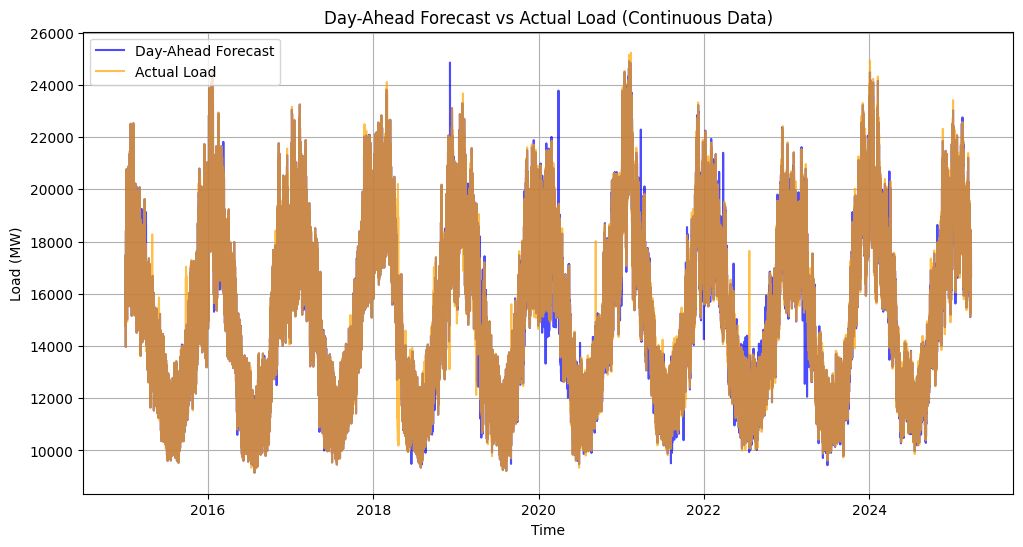

'\nimport pandas as pd\nimport os\nimport matplotlib.pyplot as plt\n\n# Example for file path\ndata_folder = "Data"\nexcel_files = sorted([f for f in os.listdir(data_folder) if f.endswith(\'.xlsx\')])  # Sort files chronologically\n\nall_data = pd.DataFrame()\n\n# Manually define the initial start date\ncurrent_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file\n\nfor file in excel_files:\n    file_path = os.path.join(data_folder, file)\n    # Read Excel file\n    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows\n\n    # Rename columns\n    data.columns = [\'Time\', \'Forecast Load\', \'Actual Load\']\n\n    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic\n    filtered_data = pd.DataFrame()\n    count = 0  # Counter for rows\n    skip = 1  # Tracks rows to be skipped\n\n    for index, row in data.iterrows():\n        # If we are in the skipping phase, decrement the skip counter and continue\n        if skip > 

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re

# Define file paths
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

all_data = pd.DataFrame()

for file in excel_files:
    file_path = os.path.join(data_folder, file)

    # Extract year from filename (filename is just "2014.xlsx", "2015.xlsx", etc.)
    file_year = os.path.splitext(file)[0]  # Removes .xlsx and takes only the year

    # Read Excel file, skipping 6 rows
    data = pd.read_excel(file_path, skiprows=6, dtype=str)

    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']
    
    # Rename second row with year-specific timestamp
    data.iloc[0] = [f'01.01.{file_year}', '', '']

    # Drop fully empty rows
    data = data.dropna(how='all')

    # Identify rows with date markers (xx.xx.xxxx format)
    date_mask = data['Time'].str.match(r'\d{2}\.\d{2}\.\d{4}', na=False)
    data['Is_Date'] = date_mask
    
    # Fill forward the date values
    data['Date'] = data.loc[data['Is_Date'], 'Time']
    data['Date'] = data['Date'].ffill()
    
    # Remove the rows that contain only the date markers
    data = data[~data['Is_Date']]
    
    # Convert "Time" format from "HH:MM - HH:MM" to just "HH:MM"
    data['Time'] = data['Time'].str.split(' - ').str[0]
    
    # Combine Date and Time to create full timestamp
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d.%m.%Y %H:%M', errors='coerce')
    
    # Convert Forecast and Actual Load to numeric, handling errors
    data['Forecast Load'] = pd.to_numeric(data['Forecast Load'], errors='coerce')
    data['Actual Load'] = pd.to_numeric(data['Actual Load'], errors='coerce')

    # Append cleaned data
    all_data = pd.concat([all_data, data[['Timestamp', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Verify the range of the data
print("Time range in data:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())

# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)')
plt.legend()
plt.grid()
plt.show()

'''
# --- **INSERT CODE FOR HANDLING MISSING LAST TWO MONTHS HERE** ---
last_year_data = all_data['Timestamp'].dt.year.max() # Identify the last year in your data
missing_months = [10, 11, 12] # November and December

# 1. Identify timestamps for the missing last two months of the last year
start_missing_date = pd.to_datetime(f'2024-10-31 11:00:00')
end_missing_date = pd.to_datetime(f'{last_year_data}-12-31 23:00:00')
missing_timestamps = pd.date_range(start=start_missing_date, end=end_missing_date, freq='H') # Hourly timestamps

# 2. Filter historical data (excluding the last year) and for Nov/Dec
historical_data = all_data[all_data['Timestamp'].dt.year < 2024]
historical_nov_dec = historical_data[historical_data['Timestamp'].dt.month.isin(missing_months)]

# 3. Calculate average hourly load for Nov/Dec across historical years
average_hourly_load = historical_nov_dec.groupby(historical_nov_dec['Timestamp'].dt.hour).agg(
    {'Forecast Load': 'mean', 'Actual Load': 'mean'}
).rename(columns={'Forecast Load': 'Avg Forecast Load', 'Actual Load': 'Avg Actual Load'})

# 4. Create a DataFrame for the missing months with imputed values
imputed_data_list = []
for ts in missing_timestamps:
    hour = ts.hour
    if hour in average_hourly_load.index: # Make sure hour exists in average data (should always be true for hourly data)
        imputed_data_list.append({
            'Timestamp': ts,
            'Forecast Load': average_hourly_load.loc[hour, 'Avg Forecast Load'],
            'Actual Load': average_hourly_load.loc[hour, 'Avg Actual Load']
        })

imputed_data_df = pd.DataFrame(imputed_data_list)

# 5. Concatenate imputed data with the original all_data
all_data = pd.concat([all_data, imputed_data_df], ignore_index=True)

# Sort by timestamp to maintain chronological order
all_data = all_data.sort_values(by='Timestamp').reset_index(drop=True)

# Verify the range of the data *after* imputation
print("Time range in data after imputation:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())


# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)')
plt.legend()
plt.grid()
plt.show()
'
'''


# Old Code
"""
import pandas as pd
import os
import matplotlib.pyplot as plt

# Example for file path
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

all_data = pd.DataFrame()

# Manually define the initial start date
current_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file

for file in excel_files:
    file_path = os.path.join(data_folder, file)
    # Read Excel file
    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows

    # Rename columns
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic
    filtered_data = pd.DataFrame()
    count = 0  # Counter for rows
    skip = 1  # Tracks rows to be skipped

    for index, row in data.iterrows():
        # If we are in the skipping phase, decrement the skip counter and continue
        if skip > 0:
            skip -= 1
            continue

        # Include the current row in the filtered_data
        filtered_data = pd.concat([filtered_data, pd.DataFrame([row])])
        count += 1

        # Once 24 rows are processed, skip the next 3 rows and reset the counter
        if count == 24:
            skip = 3  # Set skip counter for the next 3 rows
            count = 0  # Reset the counter

    # Generate timestamps dynamically based on the current_datetime
    num_rows = len(filtered_data)
    time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='h')
    filtered_data['Time'] = time_range

    # Update current_datetime to continue from the end of this file's data
    current_datetime = time_range[-1] + pd.Timedelta(hours=1)

    # Convert columns to numeric, preserving NaN values
    filtered_data['Forecast Load'] = pd.to_numeric(filtered_data['Forecast Load'], errors='coerce')
    filtered_data['Actual Load'] = pd.to_numeric(filtered_data['Actual Load'], errors='coerce')

    # Append to the combined DataFrame
    all_data = pd.concat([all_data, filtered_data[['Time', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Verify the range of the data
print("Time range in data:", all_data['Time'].min(), "to", all_data['Time'].max())

# Plot the data, including null values
plt.figure(figsize=(12, 6))
plt.plot(all_data['Time'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Time'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (With Skipped Rows)')
plt.legend()
plt.grid()
plt.show()
"""


## Data Visualization

### Plots Created:
1. Forecast vs Actual Load (Time Series)
2. Yearly Trend Analysis
3. Forecast Error Over Time
4. Missing Data Heatmap


In [3]:
print(data.head())       # Check first few rows
print(data.describe())   # Statistical summary
print(data.isnull().sum())  # Missing values


    Time  Forecast Load  Actual Load  Is_Date        Date           Timestamp
1  00:00        17782.0      17755.0    False  01.01.2025 2025-01-01 00:00:00
2  01:00        17860.0      17978.0    False  01.01.2025 2025-01-01 01:00:00
3  02:00        17827.0      17910.0    False  01.01.2025 2025-01-01 02:00:00
4  03:00        17818.0      17771.0    False  01.01.2025 2025-01-01 03:00:00
5  04:00        17728.0      18078.0    False  01.01.2025 2025-01-01 04:00:00
       Forecast Load   Actual Load                      Timestamp
count    2757.000000   2617.000000                          29641
mean    18502.992746  18624.748185  2025-07-28 22:28:27.877602048
min     15105.000000  15124.000000            2025-01-01 00:00:00
25%     17245.000000  17302.000000            2025-05-14 11:15:00
50%     18337.000000  18530.000000            2025-07-30 15:45:00
75%     19699.000000  19866.000000            2025-10-15 20:15:00
max     23028.000000  23414.000000            2025-12-31 23:45:00
std 

### Analyse Data Each Year

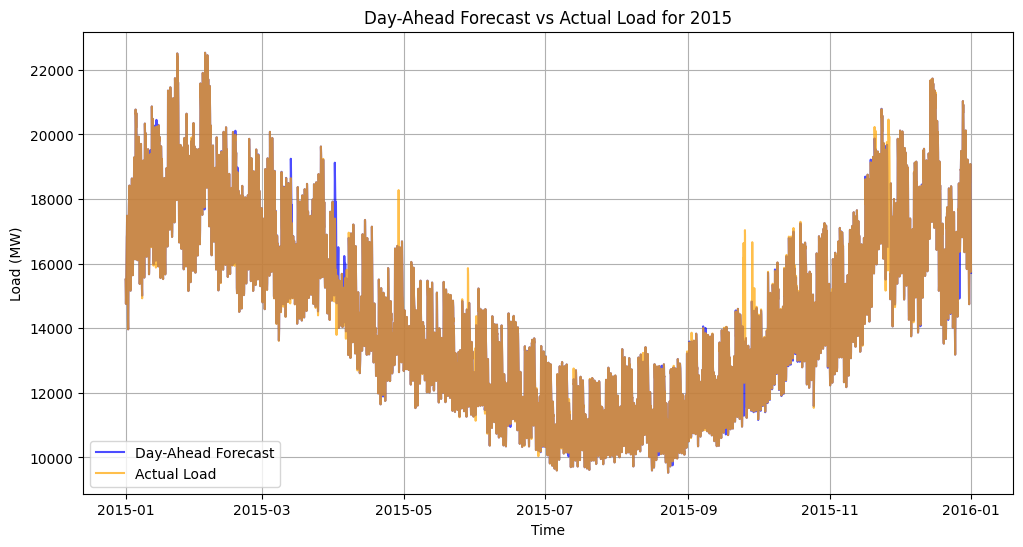

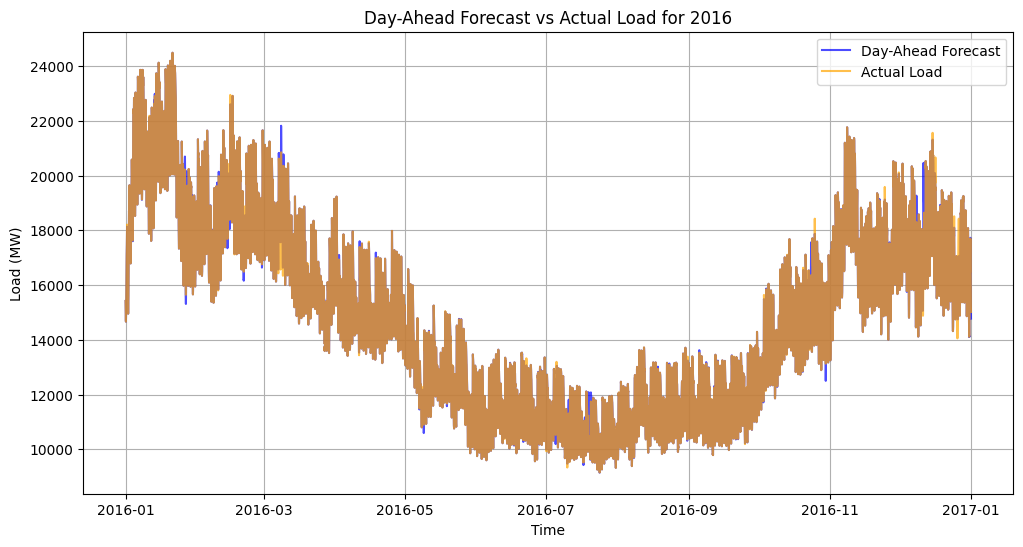

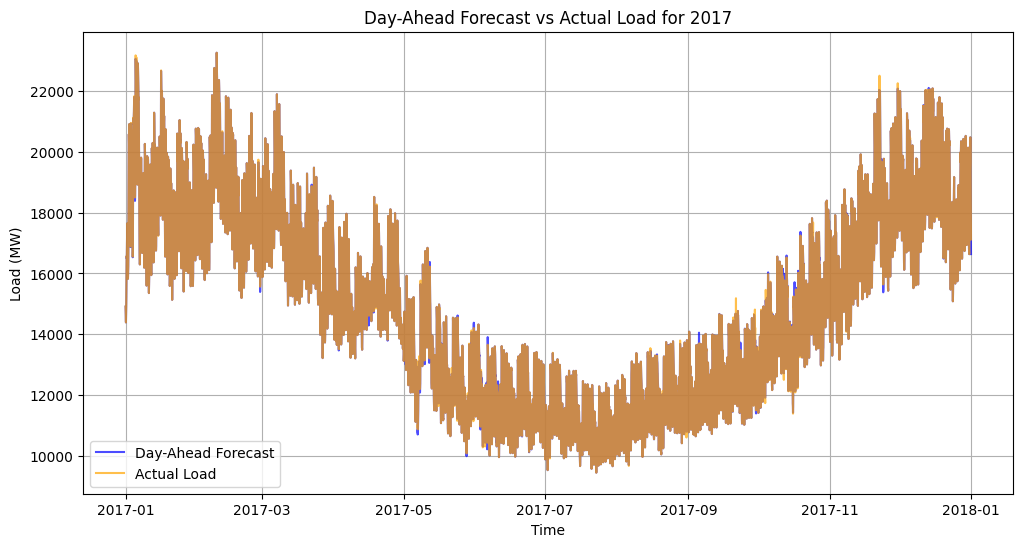

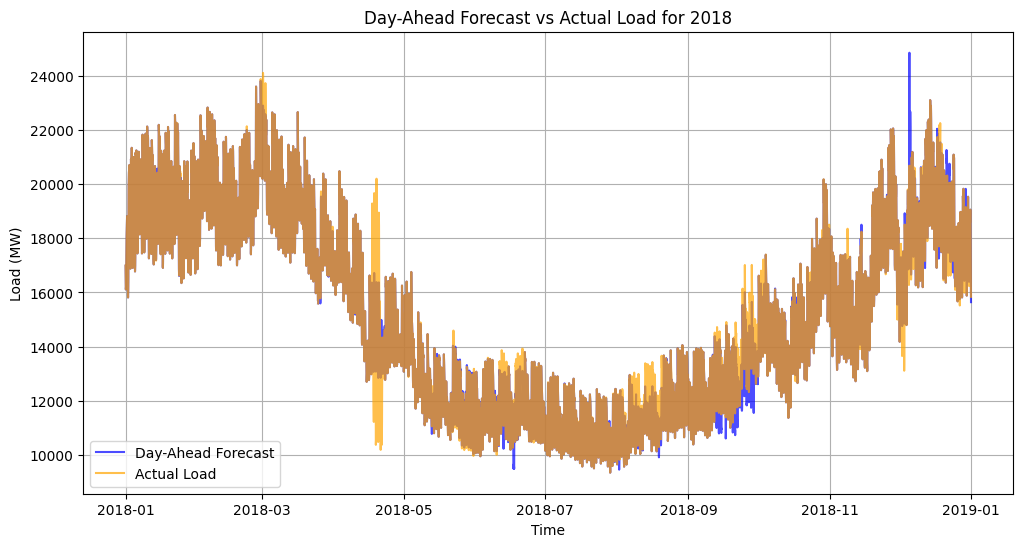

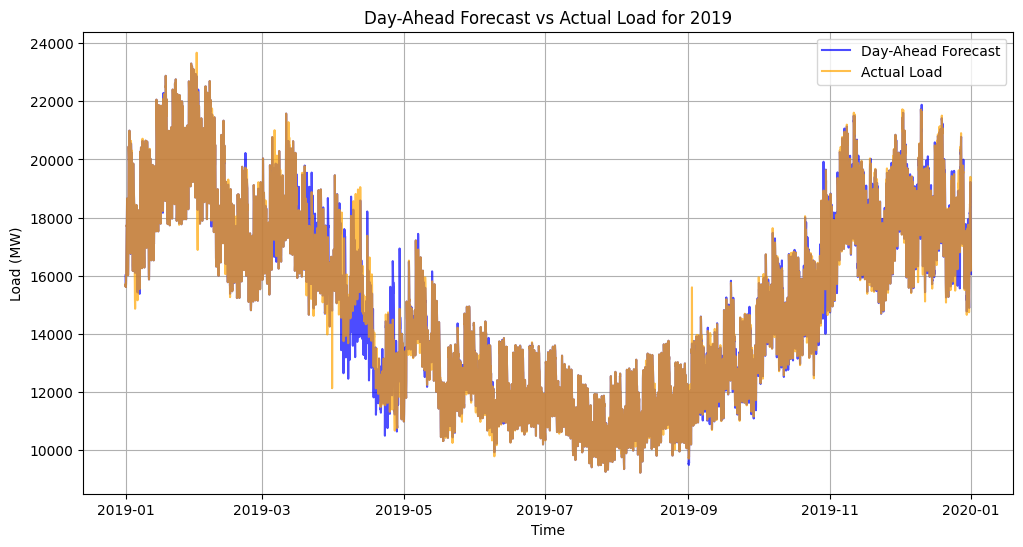

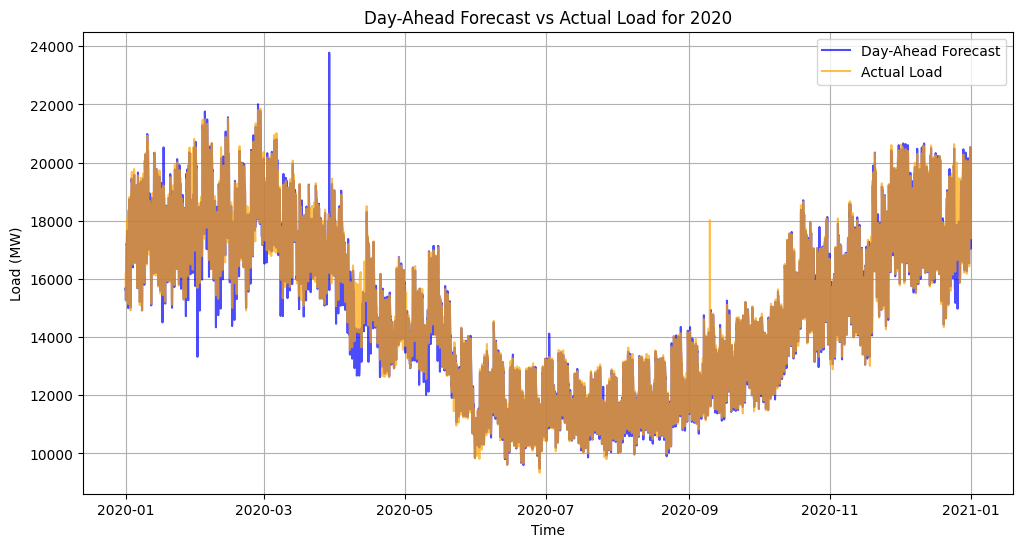

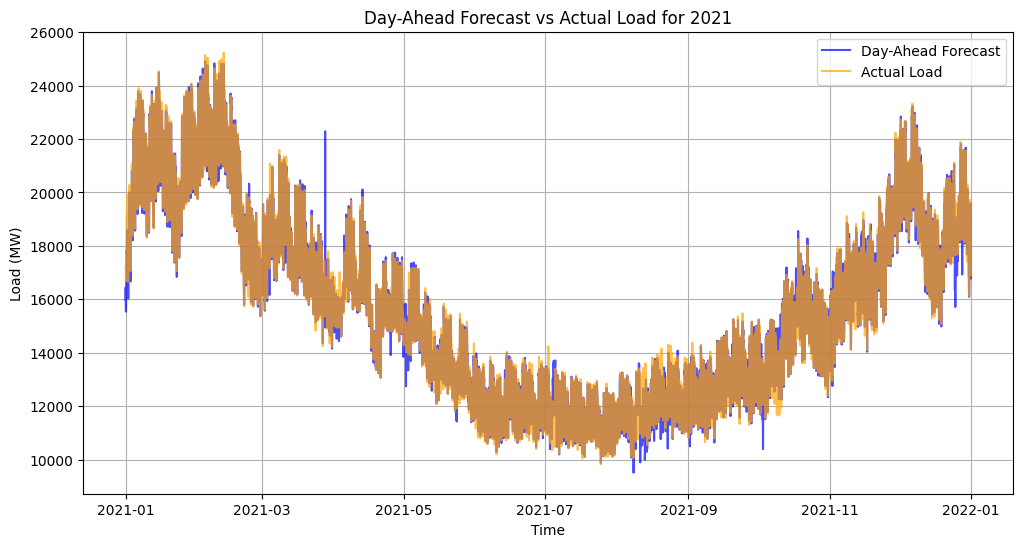

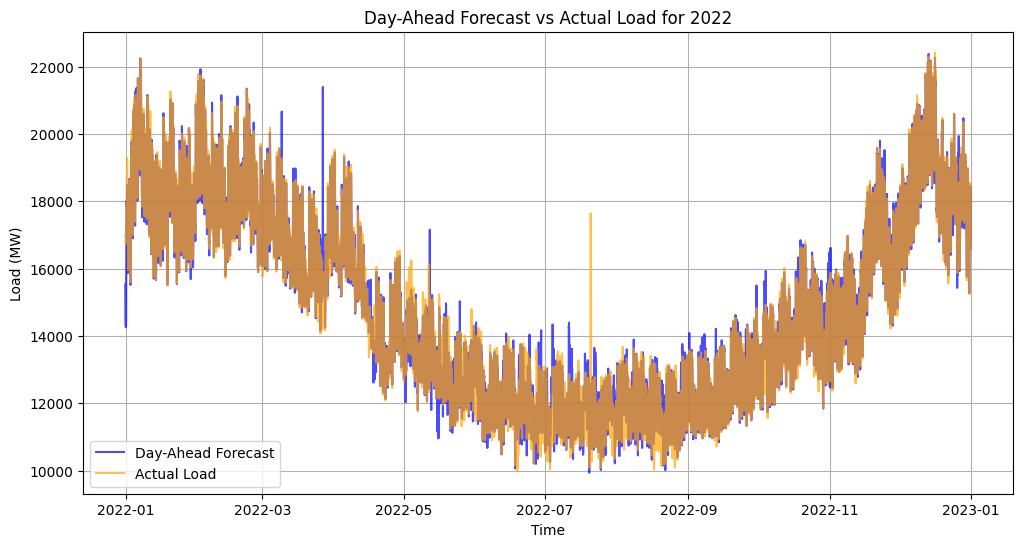

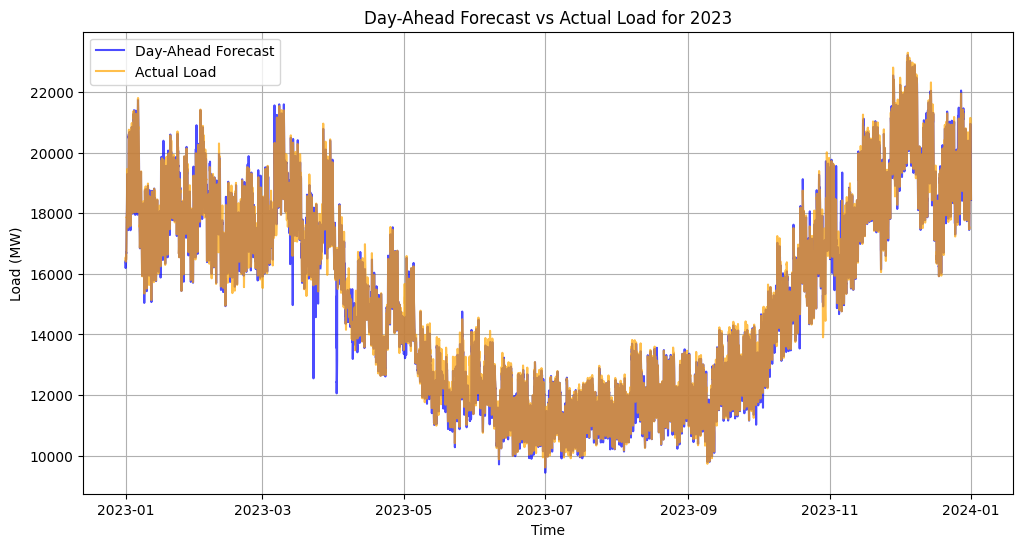

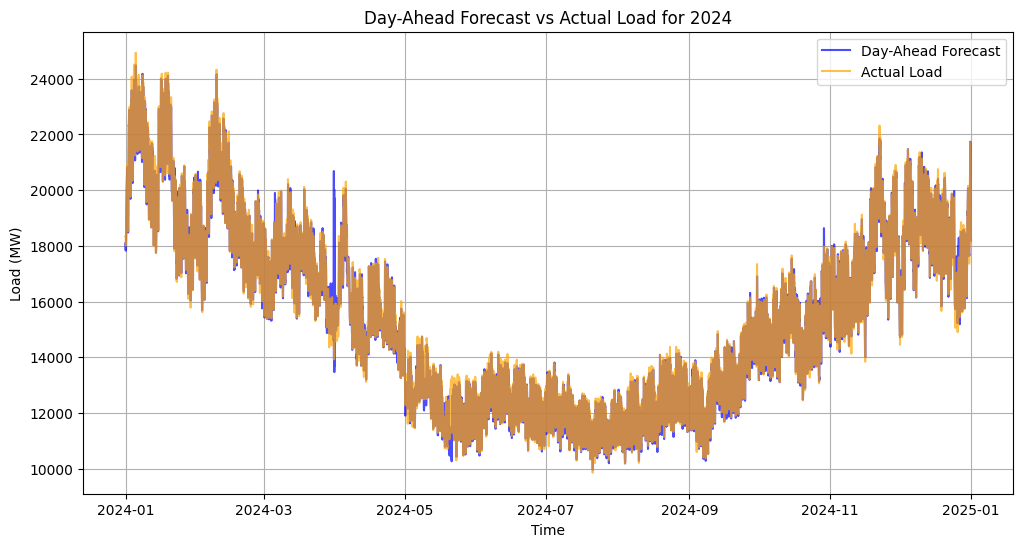

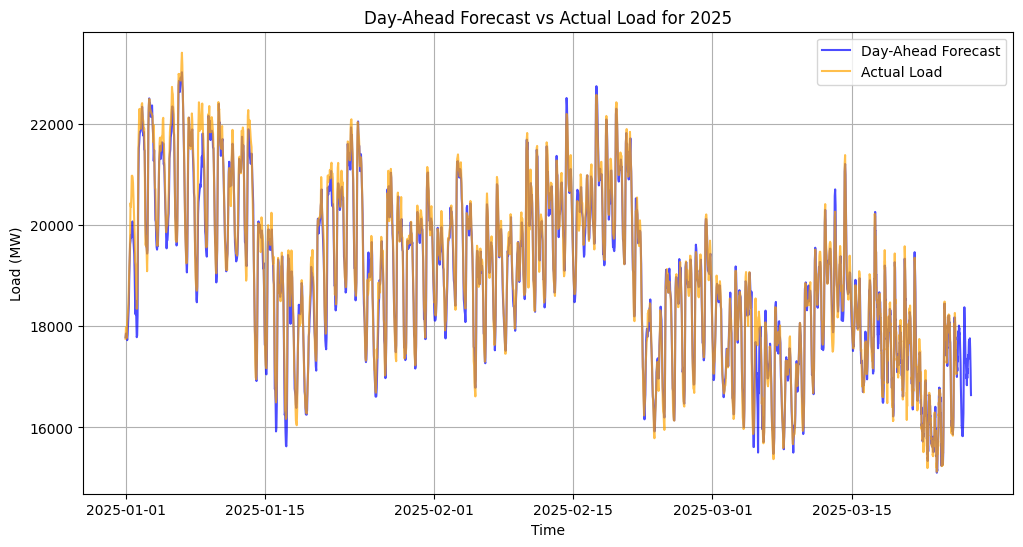

In [4]:
# Group data by year
for year, year_data in all_data.groupby(all_data['Timestamp'].dt.year):
    plt.figure(figsize=(12, 6))
    plt.plot(year_data['Timestamp'], year_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
    plt.plot(year_data['Timestamp'], year_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.title(f'Day-Ahead Forecast vs Actual Load for {year}')
    plt.legend()
    plt.grid()
    plt.show()


## Exploratory Data Analysis (EDA)

### What we analyzed:
- Summary statistics
- Missing values
- Time range verification

### Summary Statistics

In [5]:
# Ensure 'Timestamp' is in datetime format
all_data['Year'] = all_data['Timestamp'].dt.year  # Extract the year

# Group by year and calculate statistics
summary_stats = all_data.groupby('Year').agg({
    'Forecast Load': ['mean', 'max', 'min'],
    'Actual Load': ['mean', 'max', 'min']
})

# Print summary statistics
print(summary_stats)




     Forecast Load                     Actual Load                  
              mean      max      min          mean      max      min
Year                                                                
2015  14679.735119  22531.0   9527.0  14689.310388  22530.0   9527.0
2016  15073.934882  24485.0   9147.0  15070.784101  24485.0   9157.0
2017  15170.839155  23246.0   9458.0  15169.687215  23246.0   9457.0
2018  15400.935388  24854.0   9342.0  15467.212557  24108.0   9343.0
2019  15224.333447  23300.0   9217.0  15236.381963  23672.0   9217.0
2020  15100.248634  23779.0   9476.0  15125.462090  21861.0   9338.0
2021  15831.555708  24911.0   9508.0  15857.231735  25230.0   9820.0
2022  15015.697146  22379.0   9938.0  15023.900457  22416.0   9992.0
2023  15312.009932  23229.0   9435.0  15352.816210  23305.0   9608.0
2024  15554.240779  24480.0   9965.0  15577.568420  24930.0   9862.0
2025  18502.992746  23028.0  15105.0  18624.748185  23414.0  15124.0


### Comment Summary stats
burasini inceledigmizde goruyoruz ki 2014 yilinin gunde en az harcandigi enerji miktarri 14295.0
lakin diger yillara baktigimizda 2015 ve sonrasi icin geneli 9500 kusurde. Bunun nedeni 2014 yilinin sadece aralik ayinin degerlendirilmesi diger verilerin olmamasi yani yaz ve kis kiyaslamasi yok.



### Saving Processed Data

In [6]:
all_data.to_csv('combined_data.csv', index=False)


### Handle Missing Data

In [7]:
print("Missing Values Summary:")
print(all_data.isnull().sum())


Missing Values Summary:
Timestamp            0
Forecast Load    26918
Actual Load      27050
Year                 0
dtype: int64


### Dahiyane Plot

In [8]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display


# Define aggregation options
aggregation_options = {
    "Raw Data (Original)": "T",  # Minute-level
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}

# Create dropdown widget
aggregation_selector = widgets.Dropdown(
    options=aggregation_options,
    value="H",  # Default to hourly
    description="Aggregation Level:",
    style={'description_width': 'initial'}
)

# Function to plot interactive data
def plot_interactive_plotly(aggregation):
    # Resample data based on selected aggregation level
    resampled_data = all_data.set_index('Timestamp').resample(aggregation).mean().reset_index()

    # Create figure
    fig = go.Figure()

    # Add Forecast and Actual Load lines
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Forecast Load'],
        mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')
    ))
    
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Actual Load'],
        mode='lines', name='Actual Load', line=dict(color='orange')
    ))

    # Highlight No-Wind Periods (if both values are NaN)
    no_wind_periods = resampled_data[(resampled_data['Forecast Load'].isna()) & (resampled_data['Actual Load'].isna())]

    fig.add_trace(go.Scatter(
        x=no_wind_periods['Timestamp'], y=[None] * len(no_wind_periods),
        mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')
    ))

    # Update layout
    fig.update_layout(
        title=f'Day-Ahead Forecast vs Actual Load ({aggregation} Aggregation)',
        xaxis_title='Time',
        yaxis_title='Load (MW)',
        legend=dict(orientation="h"),
        template='plotly_white'
    )

    fig.show()

# Display interactive widget
display(widgets.interactive(plot_interactive_plotly, aggregation=aggregation_selector))


interactive(children=(Dropdown(description='Aggregation Level:', index=1, options={'Raw Data (Original)': 'T',…

### Anomalies

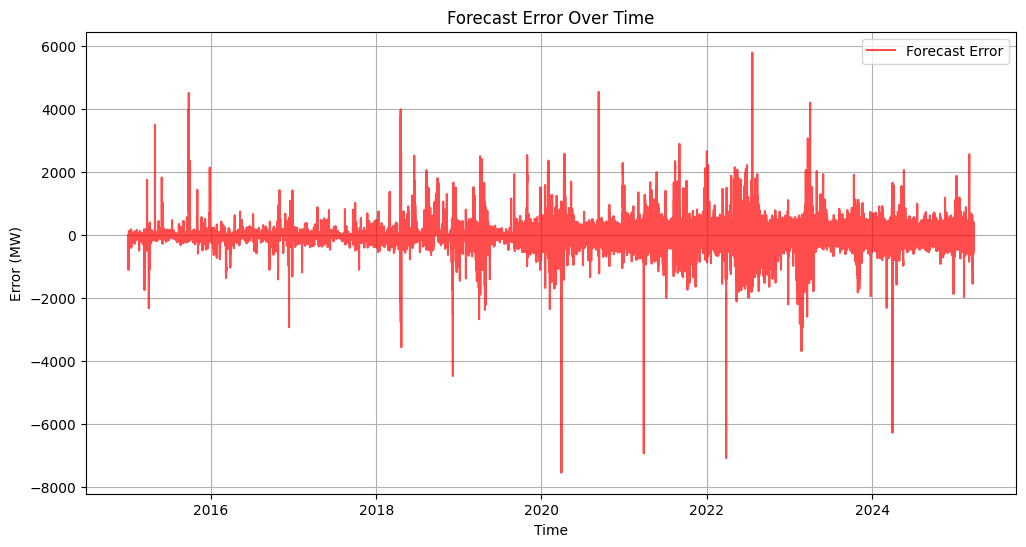

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Actual Load'] - all_data['Forecast Load'], 
         label='Forecast Error', alpha=0.7, color='red')

plt.xlabel('Time')
plt.ylabel('Error (MW)')
plt.title('Forecast Error Over Time')
plt.legend()
plt.grid()
plt.show()


### Monthly average with group by structure

In [10]:
# Ensure 'Timestamp' is in datetime format (if not already)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extract 'Year' and 'Month' from 'Timestamp'
all_data['Year'] = all_data['Timestamp'].dt.year
all_data['Month'] = all_data['Timestamp'].dt.month

# Group by 'Year' and 'Month' and calculate averages
monthly_avg = all_data.groupby(['Year', 'Month'], as_index=True)[['Forecast Load', 'Actual Load']].mean()

# Display the result
print(monthly_avg)



            Forecast Load   Actual Load
Year Month                             
2015 1       18279.598118  18265.288978
     2       18032.017857  18023.107143
     3       16560.274563  16519.551817
     4       14570.009722  14490.023611
     5       13318.690860  13331.307796
...                   ...           ...
2025 8                NaN           NaN
     9                NaN           NaN
     10               NaN           NaN
     11               NaN           NaN
     12               NaN           NaN

[132 rows x 2 columns]


### Mising Data Heat Map

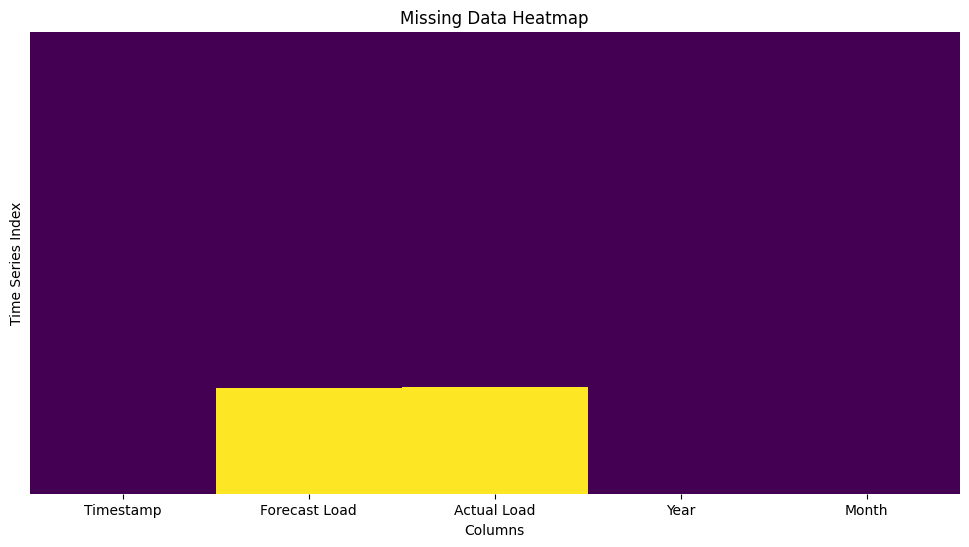

           Timestamp  Forecast Load  Actual Load  Year  Month
Timestamp                                                    
2015               0             25            1     0      0
2016               0              1           17     0      0
2017               0              1            1     0      0
2018               0              1            1     0      0
2019               0              1            1     0      0
2020               0              1            1     0      0
2021               0              1            1     0      0
2022               0              1            1     0      0
2023               0              1            1     0      0
2024               0              1            1     0      0
2025               0          26884        27024     0      0


In [11]:
import seaborn as sns

# Step 1: Identify missing value patterns over time
plt.figure(figsize=(12, 6))
sns.heatmap(all_data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Data Heatmap")
plt.xlabel("Columns")
plt.ylabel("Time Series Index")
plt.show()

# Step 2: Check missing values by year
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year).apply(lambda x: x.isnull().sum())
print(missing_by_year)



## Next Steps

**Completed:**
 Data Cleaning
 Data Exploration
 Basic Visualization

**To Do Next:**
 Feature Engineering (Rolling Averages, Lag Features)
 Outlier Detection & Handling
 Correlation Analysis
 Seasonality & Trend Analysis
 Data Imbalance Check


## Feature Engineering

### Why is Feature Engineering Important?
To improve forecasting accuracy, we create new time-dependent features such as:
- **Lag Features:** Previous values (e.g., `t-1`, `t-24`) to capture trends.
- **Rolling Averages:** Smooth short-term fluctuations.

### Steps:
1. Compute lag features.
2. Calculate rolling averages.
3. Add day-of-week and month indicators.


               Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8640 2015-12-26 23:00:00        14920.0      17065.0  2015     12   26    23   
8641 2015-12-27 00:00:00        16696.0      16695.0  2015     12   27     0   
8642 2015-12-27 01:00:00        16494.0      16494.0  2015     12   27     1   
8643 2015-12-27 02:00:00        16412.0      16411.0  2015     12   27     2   
8644 2015-12-27 03:00:00        16369.0      16369.0  2015     12   27     3   

      Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_6H_Actual  \
8640        5           1          17328.0  ...       17795.666667   
8641        6           1          14920.0  ...       17522.166667   
8642        6           1          16696.0  ...       17235.500000   
8643        6           1          16494.0  ...       16952.333333   
8644        6           1          16412.0  ...       16726.833333   

      Rolling_24H_Forecast  Rolling_24H_Actual  Rolling_168H_Forecast  \
8640          16621.00000

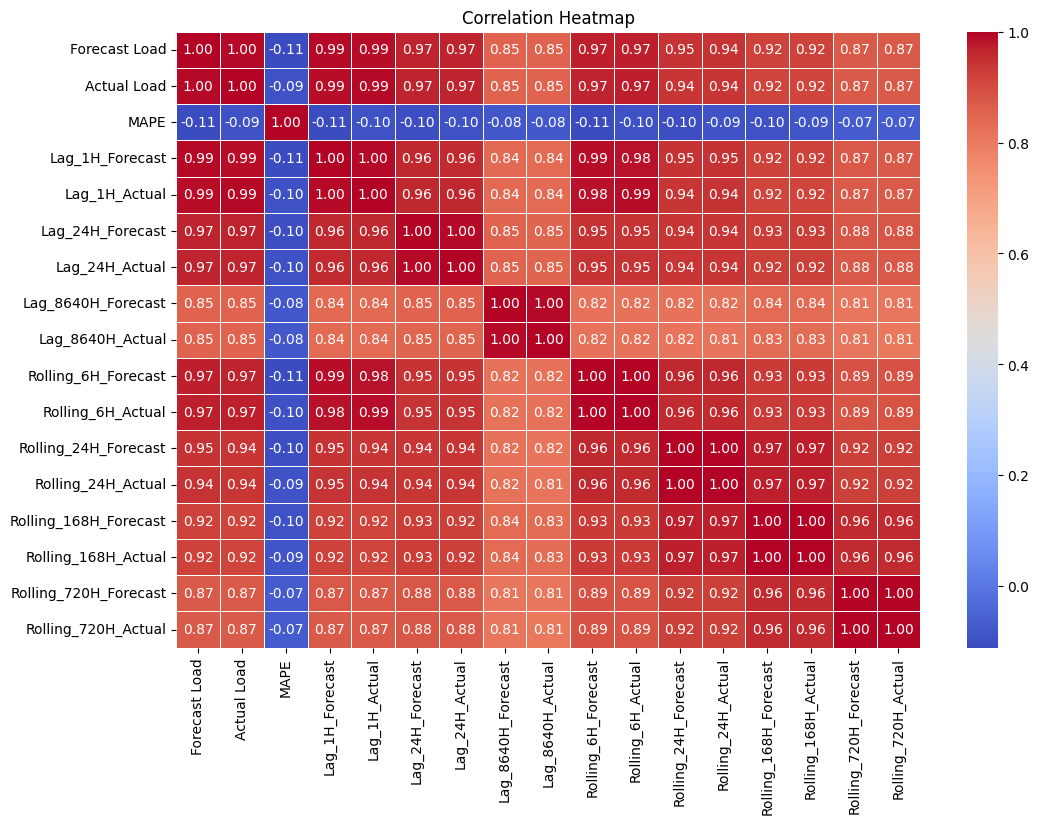

In [12]:
# Convert 'Timestamp' to datetime
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extracting additional time-based features
all_data.loc[:, 'Year'] = all_data['Timestamp'].dt.year
all_data.loc[:, 'Month'] = all_data['Timestamp'].dt.month
all_data.loc[:, 'Day'] = all_data['Timestamp'].dt.day
all_data.loc[:, 'Hour'] = all_data['Timestamp'].dt.hour
all_data.loc[:, 'Weekday'] = all_data['Timestamp'].dt.weekday  # Monday=0, Sunday=6
all_data.loc[:, 'Is_Weekend'] = all_data['Weekday'].isin([5, 6]).astype(int)

# Creating lag features
    # One hour lag
all_data.loc[:, 'Lag_1H_Forecast'] = all_data['Forecast Load'].shift(1)
all_data.loc[:, 'Lag_1H_Actual'] = all_data['Actual Load'].shift(1)
    # One Day lag
all_data.loc[:, 'Lag_24H_Forecast'] = all_data['Forecast Load'].shift(24)
all_data.loc[:, 'Lag_24H_Actual'] = all_data['Actual Load'].shift(24)
    # One Year lag
all_data.loc[:, 'Lag_8640H_Forecast'] = all_data['Forecast Load'].shift(8640)
all_data.loc[:, 'Lag_8640H_Actual'] = all_data['Actual Load'].shift(8640)


# Rolling mean features
    # Six hour window
all_data.loc[:, 'Rolling_6H_Forecast'] = all_data['Forecast Load'].rolling(window=6, min_periods=1).mean()
all_data.loc[:, 'Rolling_6H_Actual'] = all_data['Actual Load'].rolling(window=6, min_periods=1).mean()
    # One day window
all_data.loc[:, 'Rolling_24H_Forecast'] = all_data['Forecast Load'].rolling(window=24, min_periods=1).mean()
all_data.loc[:, 'Rolling_24H_Actual'] = all_data['Actual Load'].rolling(window=24, min_periods=1).mean()
    # One week window
all_data.loc[:, 'Rolling_168H_Forecast'] = all_data['Forecast Load'].rolling(window=168, min_periods=1).mean()
all_data.loc[:, 'Rolling_168H_Actual'] = all_data['Actual Load'].rolling(window=168, min_periods=1).mean()
    # One month window
all_data.loc[:, 'Rolling_720H_Forecast'] = all_data['Forecast Load'].rolling(window=720, min_periods=1).mean()
all_data.loc[:, 'Rolling_720H_Actual'] = all_data['Actual Load'].rolling(window=720, min_periods=1).mean()

"""    # One year window
all_data.loc[:, 'Rolling_8640H_Forecast'] = all_data['Forecast Load'].rolling(window=8640, min_periods=1).mean()
all_data.loc[:, 'Rolling_8640H_Actual'] = all_data['Actual Load'].rolling(window=8640, min_periods=1).mean()
"""

# Difference between forecast and actual load
all_data.loc[:, 'Load_Error'] = all_data['Forecast Load'] - all_data['Actual Load']
all_data.loc[:, 'Absolute_Error'] = abs(all_data['Load_Error'])

# Percentage error (MAPE) with a safeguard for division by zero
all_data.loc[:, 'MAPE'] = (all_data['Absolute_Error'] / (all_data['Actual Load'] + 1e-6)) * 100

# Handling missing values that may arise due to lag features
all_data = all_data.dropna()

# Display processed data sample
print(all_data.head())


# Select relevant numerical columns only (excluding non-existent or highly NaN features)
columns_to_include = [
    'Forecast Load', 'Actual Load', 'MAPE', 
    'Lag_1H_Forecast', 'Lag_1H_Actual', 'Lag_24H_Forecast', 'Lag_24H_Actual', 'Lag_8640H_Forecast', 'Lag_8640H_Actual',
    'Rolling_6H_Forecast', 'Rolling_6H_Actual', 'Rolling_24H_Forecast', 'Rolling_24H_Actual', 
    'Rolling_168H_Forecast', 'Rolling_168H_Actual', 'Rolling_720H_Forecast', 'Rolling_720H_Actual'
]

# Ensure only existing columns are selected (avoiding errors)
columns_to_include = [col for col in columns_to_include if col in all_data.columns]

# Compute correlation matrix
corr_matrix = all_data[columns_to_include].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


### Why Model implemntation

### 1. Strategy for the Last Missing Month
Since the missing data is at the end of your time-series (the final month of 2024), and reservoir computing relies on temporal patterns, we need a method that:
Respects nonlinear dynamics and temporal dependencies.
Is computationally efficient (avoids slow methods like GPR for large gaps).
Integrates seamlessly with your existing preprocessing and feature engineering.
Combine temporal feature engineering with a lightweight machine learning model to impute the missing month efficiently.

### 2. Hybrid Imputation
1. Leverage Temporal Features
Use your existing feature-engineered variables (rolling windows, lag features, etc.) to predict the missing values. For example:
Lag Features: Use the 24-hour lagged load values.
Rolling Statistics: Incorporate 24-hour rolling mean/median.
Weather Data: If available, use temperature, humidity, and wind speed as predictors.
2. Train a Lightweight Model
Use a Random Forest Regressor or XGBoost to predict the missing month. These models:
Handle nonlinear relationships efficiently.
Are faster than GPR/LSTM for large datasets.
Work well with feature-engineered temporal variables.
When it is large missing values, we can not use linear interpolation


### Why? 
Since the missing data is at the end of your time-series (the final month of 2024), and reservoir computing relies on temporal patterns, we need a method that:
Respects nonlinear dynamics and temporal dependencies.
Is computationally efficient (avoids slow methods like GPR for large gaps).
Integrates seamlessly with your existing preprocessing and feature engineering.

1. Is It Common to Use Models for Missing Value Imputation?
Using models to impute missing values is standard practice in many fields, especially when:
The missing data is structured (e.g., large gaps in time-series).
The relationships in the data are nonlinear or complex.
Simple methods (mean, linear interpolation) fail to preserve temporal dynamics.

Examples of Model-Based Imputation:
Time-Series Forecasting Models: ARIMA, Prophet, or LSTM to predict missing values.
Machine Learning Models: Random Forest, XGBoost, or k-NN to learn patterns from existing data and fill gaps.
Hybrid Methods: Combine domain knowledge (e.g., weather data) with models.

2. Why Your Case Requires Model-Based Imputation
Your missing data is the last month of a 10-year dataset, which is a large, contiguous gap. Simple interpolation (linear/cubic) will fail here because:
It assumes local smoothness, but a month-long gap lacks nearby data points.
Energy consumption is nonlinear and depends on external factors (weather, holidays).

### Handling last 2 Month Missing Vallues

In [13]:
'''
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def impute_last_month(data):
    """Impute the last missing month using temporal features and Random Forest."""
    # Ensure the index is a datetime index
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    # Define the missing period
    missing_start = '2024-11-01'
    missing_end = '2024-12-31'
    
    # Check if the missing period exists in the data
    if data.index.max() < pd.Timestamp(missing_start):
        raise ValueError("Data does not include the missing period (December 2024).")
    
    # Create a mask for the missing period
    missing_mask = (data.index >= missing_start) & (data.index <= missing_end)
    missing_data = data[missing_mask].copy()
    known_data = data[~missing_mask].copy()
    
    # Check if there's enough data to train the model
    if len(known_data) == 0:
        raise ValueError("No historical data available for training.")
    
    # Define features and target
    feature_columns = ['Lag_24h', 'RollingMean_24h', 'Hour', 'DayOfWeek']  # Adjust based on your features
    target_column = 'Actual Load'
    
    # Prepare training data (exclude rows with missing features)
    X_train = known_data[feature_columns].dropna()
    y_train = known_data.loc[X_train.index, target_column]
    
    # Train Random Forest model
    model = RandomForestRegressor(n_estimators=50, random_state=42)  # Smaller model for speed
    model.fit(X_train, y_train)
    
    # Prepare missing data features (ensure no NaN in features)
    X_missing = missing_data[feature_columns].dropna()
    if len(X_missing) == 0:
        raise ValueError("Missing data features are incomplete.")
    
    # Predict and fill missing values
    predictions = model.predict(X_missing)
    data.loc[X_missing.index, target_column] = predictions
    
    # Handle residual gaps with cubic interpolation
    data[target_column] = data[target_column].interpolate(method='cubic')
    
    return data
    '''

'\nimport pandas as pd\nfrom sklearn.ensemble import RandomForestRegressor\n\ndef impute_last_month(data):\n    """Impute the last missing month using temporal features and Random Forest."""\n    # Ensure the index is a datetime index\n    if not isinstance(data.index, pd.DatetimeIndex):\n        data.index = pd.to_datetime(data.index)\n    \n    # Define the missing period\n    missing_start = \'2024-11-01\'\n    missing_end = \'2024-12-31\'\n    \n    # Check if the missing period exists in the data\n    if data.index.max() < pd.Timestamp(missing_start):\n        raise ValueError("Data does not include the missing period (December 2024).")\n    \n    # Create a mask for the missing period\n    missing_mask = (data.index >= missing_start) & (data.index <= missing_end)\n    missing_data = data[missing_mask].copy()\n    known_data = data[~missing_mask].copy()\n    \n    # Check if there\'s enough data to train the model\n    if len(known_data) == 0:\n        raise ValueError("No histori

3. Why This Works
Efficiency: Random Forest trains quickly on temporal features and handles nonlinearity.

Temporal Consistency: Lag/rolling features preserve time-series patterns critical for reservoir computing.

Minimal Assumptions: Unlike statistical methods (e.g., ARIMA), this approach doesn’t assume linearity or stationarity.

4. Validation
Mask Validation: Artificially mask 1–2 weeks of known data, impute it using this method, and calculate MAE/RMSE to evaluate accuracy.

Visual Check: Plot the imputed values against historical data to ensure trends align.

In [14]:
'''
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# Define aggregation options
aggregation_options = {
    "Raw Data (Original)": "T",  # Minute-level
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}

# Create dropdown widget
aggregation_selector = widgets.Dropdown(
    options=aggregation_options,
    value="H",  # Default to hourly
    description="Aggregation Level:",
    style={'description_width': 'initial'}
)

# Function to plot interactive data
def plot_interactive_plotly(aggregation):
    # Resample data based on selected aggregation level
    resampled_data = all_data.set_index('Timestamp').resample(aggregation).mean().reset_index()

    # Create figure
    fig = go.Figure()

    # Add Forecast and Actual Load lines
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Forecast Load'],
        mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')
    ))
    
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Actual Load'],
        mode='lines', name='Actual Load', line=dict(color='orange')
    ))

    # Highlight No-Wind Periods (if both values are NaN)
    no_wind_periods = resampled_data[(resampled_data['Forecast Load'].isna()) & (resampled_data['Actual Load'].isna())]

    fig.add_trace(go.Scatter(
        x=no_wind_periods['Timestamp'], y=[None] * len(no_wind_periods),
        mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')
    ))

    # Update layout
    fig.update_layout(
        title=f'Day-Ahead Forecast vs Actual Load ({aggregation} Aggregation)',
        xaxis_title='Time',
        yaxis_title='Load (MW)',
        legend=dict(orientation="h"),
        template='plotly_white'
    )

    fig.show()

# Display interactive widget
display(widgets.interactive(plot_interactive_plotly, aggregation=aggregation_selector))
'''

'\nimport plotly.graph_objects as go\nimport ipywidgets as widgets\nfrom IPython.display import display\n\n# Define aggregation options\naggregation_options = {\n    "Raw Data (Original)": "T",  # Minute-level\n    "Hourly": "H",\n    "Daily": "D",\n    "Weekly": "W",\n    "Monthly": "M",\n    "Yearly": "Y"\n}\n\n# Create dropdown widget\naggregation_selector = widgets.Dropdown(\n    options=aggregation_options,\n    value="H",  # Default to hourly\n    description="Aggregation Level:",\n    style={\'description_width\': \'initial\'}\n)\n\n# Function to plot interactive data\ndef plot_interactive_plotly(aggregation):\n    # Resample data based on selected aggregation level\n    resampled_data = all_data.set_index(\'Timestamp\').resample(aggregation).mean().reset_index()\n\n    # Create figure\n    fig = go.Figure()\n\n    # Add Forecast and Actual Load lines\n    fig.add_trace(go.Scatter(\n        x=resampled_data[\'Timestamp\'], y=resampled_data[\'Forecast Load\'],\n        mode=\'lin

## Outlier Detection

### Why is it Important?
Outliers can distort predictions and must be identified.

### Steps:
1. **Visualize using Box Plots**
2. **Compute Z-Scores or IQR**
3. **Decide: Remove or Transform?**


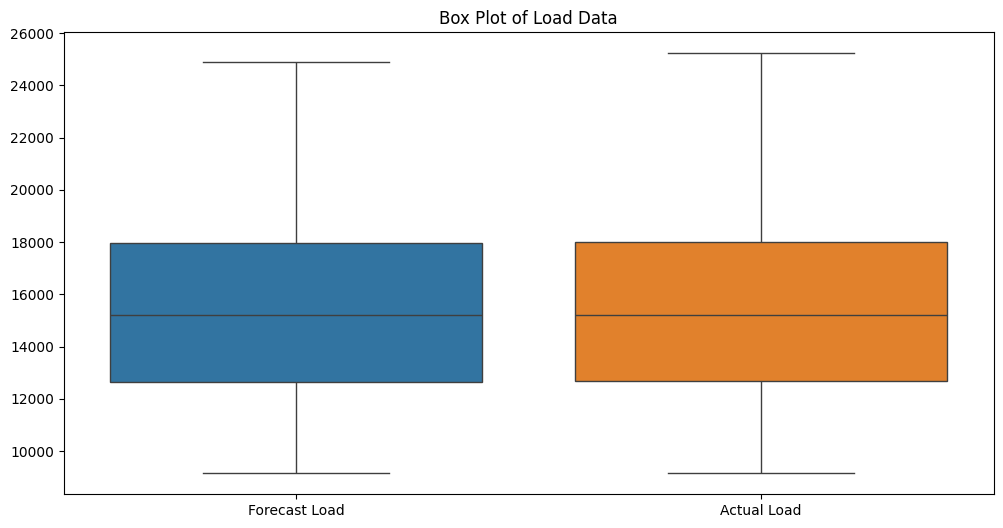

In [15]:
### *Outlier Detection Code Below:*

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data[['Forecast Load', 'Actual Load']])
plt.title('Box Plot of Load Data')
plt.show()


## Correlation Analysis

### Why is it Important?
Identifying relationships between variables helps remove redundancy.

### Steps:
1. Compute correlation matrix.
2. Visualize with a heatmap.
3. Identify highly correlated features.


In [16]:
### *Correlation Analysis Code Below:*

from scipy.stats import zscore

all_data['Forecast_Z'] = zscore(all_data['Forecast Load'])
all_data['Actual_Z'] = zscore(all_data['Actual Load'])

# Show rows where the absolute Z-score is greater than 3 (potential outliers)
outliers = all_data[(all_data['Forecast_Z'].abs() > 3) | (all_data['Actual_Z'].abs() > 3)]
print(outliers)


Q1 = all_data[['Forecast Load', 'Actual Load']].quantile(0.25)
Q3 = all_data[['Forecast Load', 'Actual Load']].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = all_data[((all_data[['Forecast Load', 'Actual Load']] < (Q1 - 1.5 * IQR)) | 
                         (all_data[['Forecast Load', 'Actual Load']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(outliers_iqr)


                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
53438 2021-02-04 08:00:00        24901.0      25146.0  2021      2    4     8   
53631 2021-02-12 09:00:00        24816.0      25230.0  2021      2   12     9   

       Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_24H_Actual  \
53438        3           0          24690.0  ...        22931.916667   
53631        4           0          24654.0  ...        23071.791667   

       Rolling_168H_Forecast  Rolling_168H_Actual  Rolling_720H_Forecast  \
53438           22242.476190         22247.148810           21424.848611   
53631           22569.380952         22615.886905           21750.120833   

       Rolling_720H_Actual  Load_Error  Absolute_Error      MAPE  Forecast_Z  \
53438         21463.245833      -245.0           245.0  0.974310    2.936837   
53631         21790.401389      -414.0           414.0  1.640904    2.910539   

       Actual_Z  
53438  3.007165  
53631  3.033167  

[2 rows x 28 c

## Time-Series Decomposition

### Why?
- Helps visualize long-term trends.
- Identifies seasonal patterns.

### Steps:
1. Use `seasonal_decompose()`.
2. Plot components (Trend, Seasonality, Residuals).
3. Decide if detrending is needed.


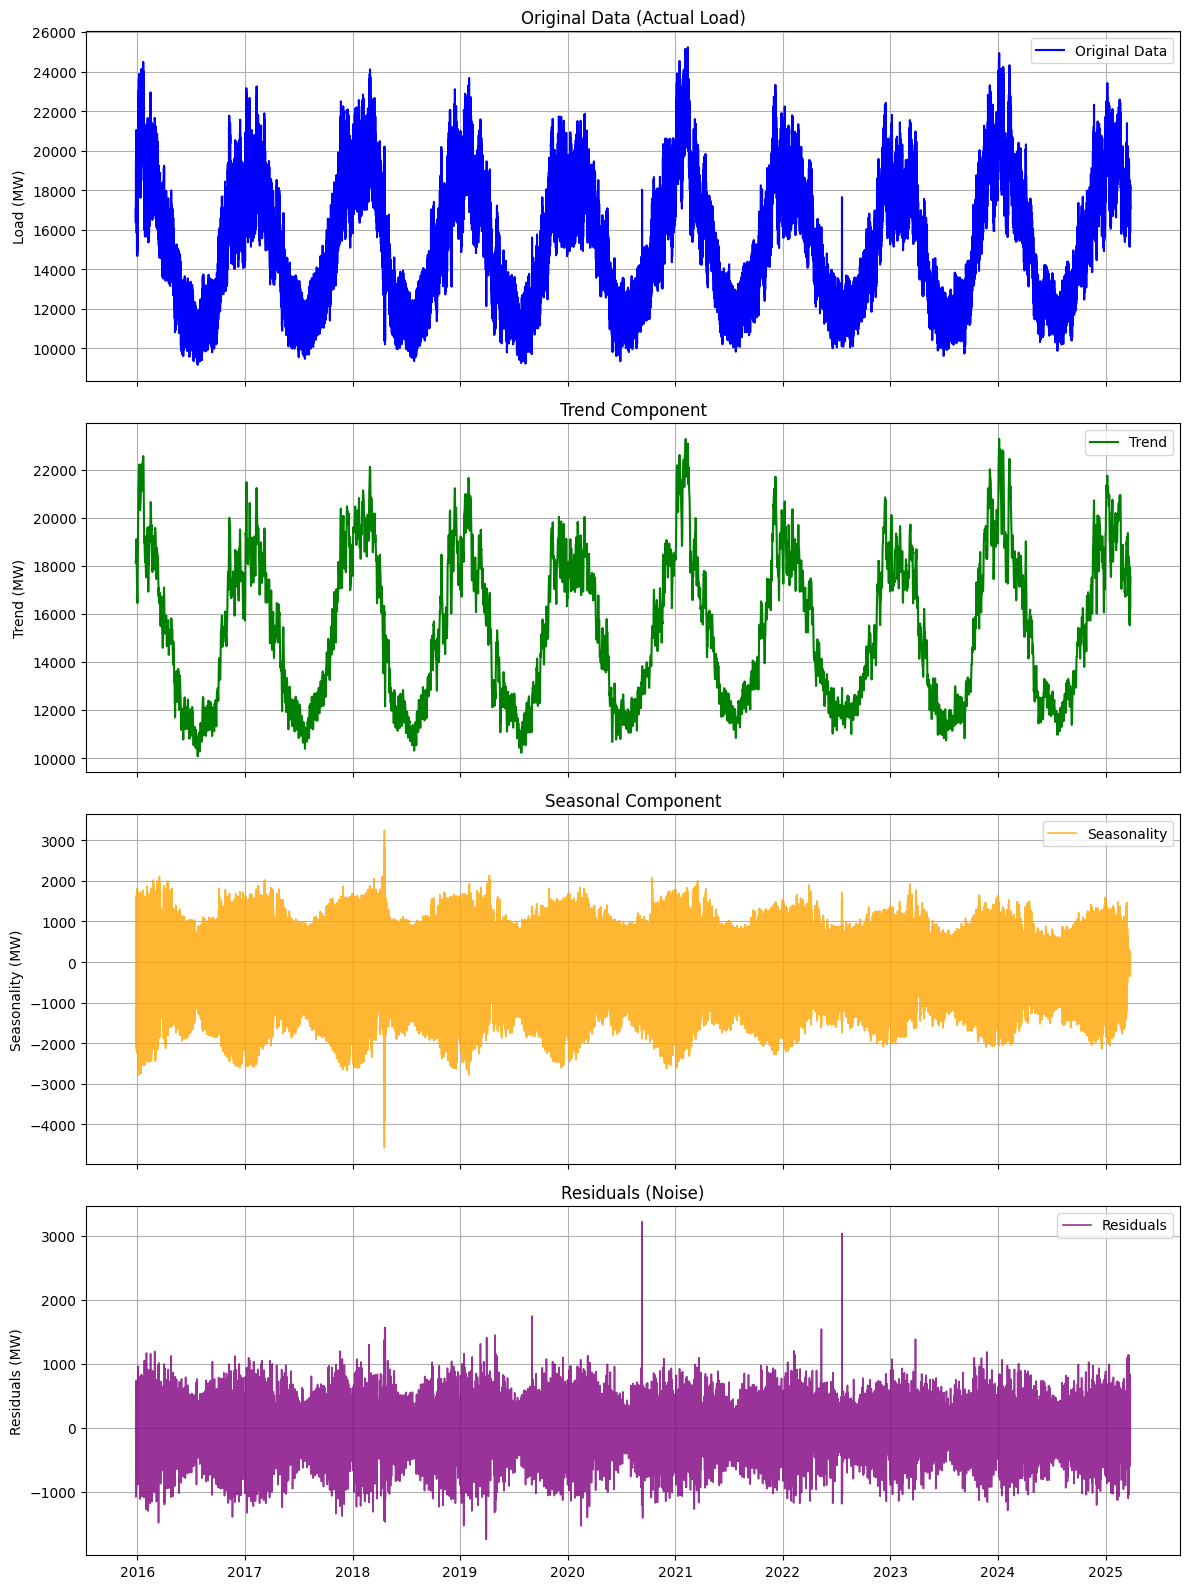

In [17]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Ensure the Timestamp is set as the index and sorted
ts = all_data.set_index('Timestamp').sort_index()

# Choose the time series to decompose (drop missing values if necessary)
series = ts['Actual Load'].dropna()

# Specify the period for the seasonal component.
# For hourly data with daily seasonality, period=24; adjust as needed.
stl = STL(series, period=24)
result = stl.fit()

# Plot each component separately for better clarity
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Original Data
axes[0].plot(series, label='Original Data', color='blue', linewidth=1.5)
axes[0].set_title('Original Data (Actual Load)')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

# Trend Component
axes[1].plot(result.trend, label='Trend', color='green', linewidth=1.5)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend (MW)')
axes[1].legend()
axes[1].grid(True)

# Seasonal Component
axes[2].plot(result.seasonal, label='Seasonality', color='orange', linewidth=1.2, alpha=0.8)
axes[2].set_title('Seasonal Component')
axes[2].set_ylabel('Seasonality (MW)')
axes[2].legend()
axes[2].grid(True)

# Residuals (Noise)
axes[3].plot(result.resid, label='Residuals', color='purple', linewidth=1.2, alpha=0.8)
axes[3].set_title('Residuals (Noise)')
axes[3].set_ylabel('Residuals (MW)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()
